# Import

In [1]:
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import savgol_filter
from scipy.stats import zscore
from tqdm.auto import tqdm

import neuroseries as nts


import time
import matplotlib.pyplot as plt

import seaborn as sns 
import bk.load
import bk.compute
import bk.plot
import bk.signal

import os
from time import sleep

import astropy.stats as apy
plt.rcParams['svg.fonttype'] = 'none'


In [2]:
def pcc(neuron_phase):
    if isinstance(neuron_phase,nts.Tsd):
        neuron_phase = neuron_phase.values.astype(np.float16)

    pcc = neuron_phase[None,:] - neuron_phase[:,None]
    pcc[np.diag_indices_from(pcc)] = np.nan
    pcc = np.cos(pcc)
    return np.nanmean(pcc,0).mean()


In [3]:
def gen_delta(freqs):
    deltas = np.zeros_like(freqs)
    for i,f in enumerate(freqs):
        if f < 8:
            deltas[i] = 4
        elif f>8 and f<20:
            deltas[i] = 4+(f-8) * 1/2
        elif f>20 and f<45:
            deltas[i] = 10 + (f-20) * 2/5
        else:
            deltas[i] = 20

    return deltas


def mean_resultant_length(angles):
    angles = np.exp(1j*angles)
    return np.abs(np.mean(angles))

def concentration(angles):
    '''
    Compute the kappa parameter Uses the approximation described in "Statistical Analysis of Circular Data" (Fisher, p. 88).
    Translated from MATLAB fmatoolbox.sourceforge.net/Contents/FMAToolbox/General/Concentration.html
    angles : radian

    Copyright (C) 2004-2011 by Michaël Zugaro
    Copyright (C) 2021 by Billel KHOUADER

    '''
    n = len(angles)
    angles = np.exp(1j * angles)  # Complex form of the angles
    r = abs(np.mean(angles))

    if r < 0.53:
        k = 2 * r + r**3 + 5*r**(5/6)
    elif r < 0.85:
        k = -0.4 + 1.39 * r + 0.43 / (1-r)
    else:
        k = 1/(r**3 - 4 * r**2 + 3*r)

    # Correction for very small samples

    if n <= 15:
        if k < 2:
            k = np.max([(k-2)/(n*k), 0])
        else:
            k = (n-1)**3 * (n**3+n)

    return k

In [4]:
def compute_mrl(neuron, phase,weights = None):
    neuron_phase = phase.realign(neuron)
    phases_distribution, bin_p = np.histogram(neuron_phase.values,100)
    phases_distribution = phases_distribution/weights

    bin_p = np.convolve(bin_p,[0.5,0.5],'same')[1::]
    return bk.compute.mean_resultant_length(bin_p,phases_distribution)


def compute_ppc(neuron, phase, n=1000):
    neuron_phase = phase.realign(neuron)
    neuron_phase = neuron_phase.values.astype(np.float16)
    if len(neuron)>n:
        neuron_phase = np.random.choice(neuron_phase, n)

    pcc = neuron_phase[None, :] - neuron_phase[:, None]
    pcc[np.diag_indices_from(pcc)] = np.nan
    pcc = np.cos(pcc)
    return np.nanmean(pcc, 0).mean()


def compute_modulation_across_frequencies(neurons, lfp, state, fmin=0.1, fmax=100, nbins=50, method='MRL'):
    freq_bins = np.linspace(fmin, fmax, nbins)
    deltas = gen_delta(freq_bins)
    bands = np.array([freq_bins-deltas/2,freq_bins+deltas/2])
    mod_freq_neurons = np.empty(shape=(len(freq_bins), len(neurons)))

    if method.lower() == 'both':
        mod_freq_neurons = {'MRL': np.empty(shape=(len(freq_bins), len(neurons))),
                            'PPC': np.empty(shape=(len(freq_bins), len(neurons)))}
    else:
        mod_freq_neurons = np.empty(shape=(len(freq_bins), len(neurons)))

    for i, f in tqdm(enumerate(freq_bins), total=len(freq_bins),desc = 'Freqs',position = 1):
        # print(f'Compute Filters at {f-deltas[i]/2} and {f+deltas[i]/2}')
        filt = bk.signal.passband(lfp, f-deltas[i]/2, f+deltas[i]/2, order=2)
        _, phase = bk.signal.hilbert(filt)
        
        phases_signal_distrib, _ = np.histogram(phase.values,100,density=True)
        weights = phases_signal_distrib*100 / np.sum(phases_signal_distrib)

        for j, n in tqdm(enumerate(neurons),desc = 'Neurons',total = len(neurons),leave = True,position = 2):
            if method.lower() == 'mrl':
                mod_freq_neurons[i, j] = compute_mrl(n.restrict(state), phase,weights)
            elif method.lower() == 'ppc':
                mod_freq_neurons[i, j] = compute_ppc(n.restrict(state), phase)
            elif method.lower() == 'both':
                mod_freq_neurons['MRL'][i,j] = compute_mrl(n.restrict(state), phase,weights)
                # mod_freq_neurons['PPC'][i,j] = compute_ppc(n.restrict(state), phase)

    return bands,freq_bins, mod_freq_neurons


In [7]:
def main_local(base_folder,local_path,*args,**kwargs):
    save = kwargs['save']
    force_compute = kwargs['force_compute']
    state = kwargs['state']
    fmin,fmax = kwargs['frange']
    nbins = kwargs['nbins']
    
    bk.load.current_session_linux(base_folder,local_path)


    if np.any(bk.load.analysis('freq_mod/freq_mod_local_200um_3_200_100_NREM.npy')):
        return('saved')
    if bk.load.rat < 10:
        return('done')
    if bk.load.day <8:
        return('donee')
    neurons, metadata = bk.load.spikes()
    states = bk.load.states()
    state = states[state]


    freq_bins = np.linspace(fmin, fmax, nbins)
    deltas = gen_delta(freq_bins)
    bands = np.array([freq_bins-deltas/2,freq_bins+deltas/2])
    mod_freq_neurons = np.zeros(shape=(len(freq_bins), len(neurons)))



    lfps = {}
    for shank in tqdm(np.unique(metadata.Shank),desc = 'LFPs'):
        shank_neighbour = bk.load.shank_neighbours(shank)
        if np.isfinite(shank_neighbour['medial']):
            neighbour_channel = bk.load.best_channel(shank_neighbour['medial'])
        else:
            neighbour_channel = bk.load.best_channel(
                shank_neighbour['lateral'])
        lfps.update({shank:bk.load.lfp_in_intervals(neighbour_channel, state)})

    
    for i, f in tqdm(enumerate(freq_bins), total=len(freq_bins),desc = 'Freqs',position = 1):
        previous_shank = 0
        for j, (n, m) in tqdm(enumerate(zip(neurons, metadata.iloc)),desc = 'Neurons',total = len(neurons),leave = True,position = 2):
            
            if previous_shank != m['Shank']:
                filt = bk.signal.passband(lfps[m['Shank']], f-deltas[i]/2, f+deltas[i]/2, order=2)
                _, phase = bk.signal.hilbert(filt)
                previous_shank = m['Shank']

            phases_signal_distrib, _ = np.histogram(phase.values,100,density=True)
            weights = phases_signal_distrib*100 / np.sum(phases_signal_distrib)
            mod_freq_neurons[i, j] = compute_mrl(n.restrict(state), phase,weights)

    np.save('Analysis/freq_mod/freq_mod_local_200um_3_200_100_NREM.npy',((freq_bins,mod_freq_neurons),metadata,bands))
    return bands,freq_bins, mod_freq_neurons


In [8]:
kwargs = {'state': 'sws',
          'frange': [3, 200],
          'nbins': 100,
          'save': True,
          'force_compute': False}
batch,metadata = bk.load.batch(main_local,local_base='/mnt/electrophy/Gabrielle/GG-Dataset-Light/',**kwargs)

100%|██████████| 61/61 [31:54:00<00:00, 1882.63s/it]  

Batch finished in 114840.26113843918
Some session were not processed correctly
['Rat11-20150402', 'Rat11-20150403']
3.278688524590164 %


In [7]:
bk.load.current_session_linux()
if np.any(bk.load.analysis('freq_mod/freq_mod_local_200um_3_200_100_NREM.npy')):
    print('yes')

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713
yes


In [9]:
kwargs = {'state': 'Rem',
          'frange': [3, 200],
          'nbins': 100,
          'save': True,
          'force_compute': False}
bands,freq_bins, mod_freq_neurons = main_local('/mnt/electrophy/Gabrielle/GG-Dataset-Light/',
           'Rat08/Rat08-20130713', **kwargs)

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713


ValueError: too many values to unpack (expected 3)

In [9]:
def main(base_folder,local_path,*args,**kwargs):
    save = kwargs['save']
    force_compute = kwargs['force_compute']
    
    bk.load.current_session_linux(base_folder,local_path)
    data = bk.load.analysis('freq_mod/freq_mod_hpc_3_150_75.npy')
    
    if data is not False and not force_compute:
        return data
    
    neurons, metadata = bk.load.spikes()
    states = bk.load.states()
    hpc_channel = bk.load.ripple_channel()
    lfp = bk.load.lfp_in_intervals(hpc_channel,states['Rem'])

    
    bands,f,mod_freq_neurons = compute_modulation_across_frequencies(neurons,lfp,states['Rem'],3,200,70,method='both')
    if save:
        os.makedirs('Analysis/freq_mod',exist_ok=True)
        np.save('Analysis/freq_mod/freq_mod_hpc_3_150_75.npy',((f,mod_freq_neurons),metadata,bands))

    return (f,mod_freq_neurons),metadata,bands

In [10]:
kwargs = {'save': True,
          'force_compute': False}
batch,metadata = bk.load.batch(main,local_base='/mnt/electrophy/Gabrielle/GG-Dataset-Light/',**kwargs)

Sessions: 100%|██████████| 61/61 [00:31<00:00,  1.92it/s]

Batch finished in 31.753708124160767
Some session were not processed correctly
['Rat08-20130712', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140325', 'Rat09-20140326', 'Rat09-20140327', 'Rat09-20140328', 'Rat09-20140329', 'Rat09-20140331', 'Rat09-20140401', 'Rat09-20140402', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat11-20150316', 'Rat11-20150402', 'Rat11-20150403']
37.704918032786885 %


In [8]:
np.save('/mnt/work/Analyse/Variables/frequency_modulation/frequency_mod_hpc_corrected',batch)

/home/billel/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [4]:
batch,metadata = np.load('/mnt/work/Analyse/Variables/frequency_modulation/frequency_mod_hpc.npy',allow_pickle=True).flatten()[0]

In [17]:
all_mod_freq_neurons = {'MRL':[],
'PPC':[]}
all_metadata = pd.DataFrame()
for b in batch:
    # if b == 'Rat08-20130713':
    f = batch[b][0][0]
    mod_freq_neurons = batch[b][0][1]
    for m in all_mod_freq_neurons:
      all_mod_freq_neurons[m].append(mod_freq_neurons[m])
    all_metadata = pd.concat((all_metadata,batch[b][1]))


      # for i in range(252):
      #   fig,ax = plt.subplots(1,2)

      #   ax[0].plot(f,mod_freq_neurons['MRL'][:,i])
      #   ax[0].set_ylim(0,0.4)
      #   ax[0].set_xlim(0,200)

      #   ax[0].set_title('MRL')
        
        
        
      #   ax[1].plot(f,mod_freq_neurons['PPC'][:,i])
      #   ax[1].set_title('PPC')
      #   ax[1].set_ylim(0,0.10)
      #   ax[1].set_xlim(0,100)
        
      #   plt.suptitle(f'#{i} - {metadata.Region.iloc[i]}')
      #   plt.tight_layout()
all_mod_freq_neurons['MRL'] = np.hstack(all_mod_freq_neurons['MRL']).T
all_mod_freq_neurons['PPC'] = np.hstack(all_mod_freq_neurons['PPC']).T

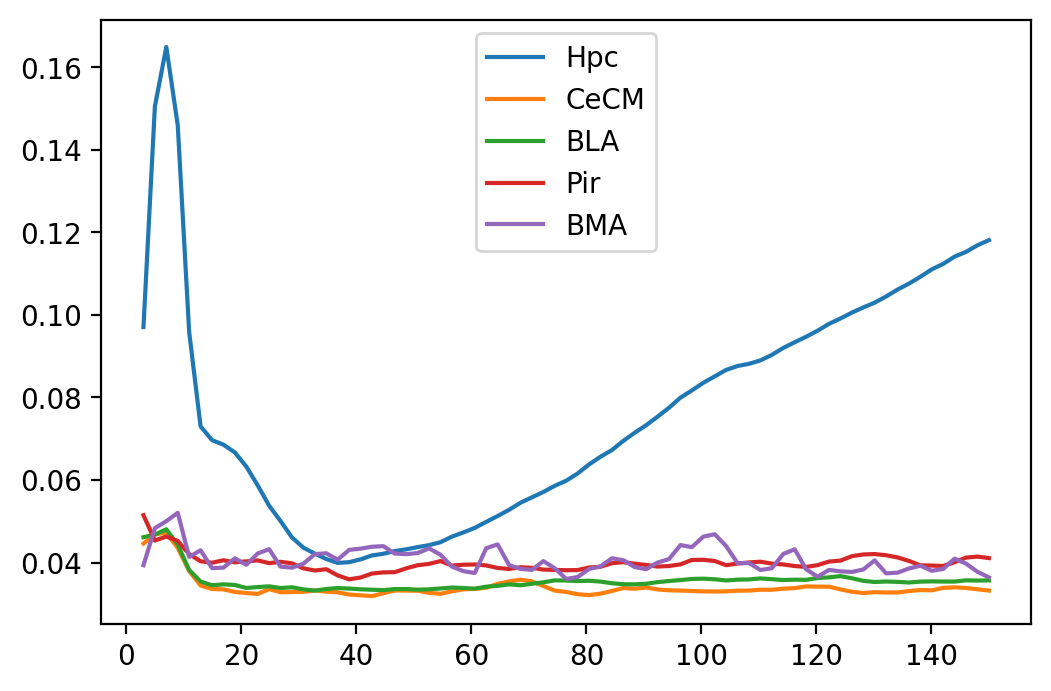

In [21]:
plt.figure(dpi =200)
structures = ['Hpc','CeCM','BLA','Pir','BMA']
for stru in structures:
    average_mrl = np.nanmean(all_mod_freq_neurons['MRL'][all_metadata.Region == stru],0)
    plt.plot(f,average_mrl)
plt.legend(structures)

Using matplotlib backend: Qt5Agg


In [15]:
for i in range(252):
    fig,ax = plt.subplots(1,2)

    ax[0].plot(f,mrls_freq_neurons[:,i])
    ax[0].set_ylim(0,0.4)
    ax[0].set_xlim(0,200)

    ax[0].set_title('MRL')
    
    
    
    ax[1].plot(f,ppc_freq_neurons[:,i])
    ax[1].set_title('PPC')
    ax[1].set_ylim(0,0.10)
    ax[1].set_xlim(0,100)
    
    plt.suptitle(f'#{i} - {metadata.Region.iloc[i]}')
    plt.tight_layout()

NameError: name 'mrls_freq_neurons' is not defined

In [23]:
freq_bins = np.arange(0,50,1)
phase_locks = []
for i in tqdm(freq_bins):
    filt = bk.signal.passband(lfp,i+0.1,i+1)
    power,phase = bk.signal.hilbert(filt)


    neurons_phase = []
    neurons_rem_fr = []
    for i, n in enumerate(neurons):
        neurons_phase.append(phase.realign(n.restrict(states['Rem'])))
        neurons_rem_fr.append(
            len(n.restrict(states['Rem']))/states['Rem'].tot_length(time_units='s'))

    pvalues = []
    kappas = []
    modulated = []
    MRLs = []
    for i, p in enumerate(neurons_phase):
        pvalue = apy.rayleightest(p.values)
        pvalues.append(pvalue)

        kappa = concentration(p.values)
        kappas.append(kappa)

        MRL = mean_resultant_length(p.values)
        MRLs.append(MRL)

        if (pvalue < 0.01) and MRL > 0.04:
            modulated.append(True)
        else:
            modulated.append(False)

    phase_lock = pd.DataFrame({'FR_Rem': neurons_rem_fr,
                               'MRL': MRLs,
                               'Kappa': kappas,
                               'pValue': pvalues,
                               'modulated': modulated})

    # pvalues = pd.DataFrame(pvalues, columns=['pValue'])
    # FRRem = pd.DataFrame(neurons_rem_fr, columns=['FRRem'])

    phase_lock = pd.concat([metadata, phase_lock], axis=1)
    phase_locks.append(phase_lock)


  0%|          | 0/50 [00:00<?, ?it/s]

NameError: name 'lfp' is not defined

In [14]:
%matplotlib qt
for j,n in enumerate(neurons[0:5]):
    plt.figure()
    for i,p in enumerate(phase_locks):
        plt.scatter(freq_bins[i]+2.5,p['MRL'][j],facecolor = 'grey')

NameError: name 'neurons' is not defined